# Concept Drift on MNIST

~ [Paper](http://proceedings.mlr.press/v32/harel14.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time, sleep
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_mldata

from sklearn.svm import SVC

import autosklearn.classification

In [2]:
# No temporal dependence in data

In [3]:
class DataStream:
    
    def __init__(self, X, y, size):
        self.iterator = iter(zip(X, y))
        self.buffer = []
        self.size = size
        self.xshape = X.shape
        self.yshape = y.shape

    def __iter__(self):
        return self

    def __next__(self):
        tmp = (np.zeros((self.size, self.xshape[1])), np.zeros((self.size, self.yshape[1])))

        for i in range(self.size):
            if self.buffer:
                tmp_iter = self.buffer.pop()
            else:
                tmp_iter = next(self.iterator)
            tmp[0][i,:] = tmp_iter[0]
            tmp[1][i,:] = tmp_iter[1]   
        return tmp

    def has_next(self):
        if self.buffer:
            return True
        try:
            self.buffer = [next(self.iterator)]
        except StopIteration:
            return False
        else:
            return True

In [4]:
def new_data_stream(data_stream, X=None, y=None):
    if X is None and y is None:
        return data_stream
    else:
        return np.concatenate((X, data_stream[0]), axis=0), np.concatenate((y, data_stream[1]), axis=0)

def concept_drift_scheme(window_size, permut, cd_size, significance_rate, data_stream):

    t_ = 0 # t_ is the first element of a stream
    k = window_size # k is the 
    D = [] # Set of change indices
    X, y = new_data_stream(data_stream.__next__(), None, None)
    times = []
    i = 1
    
    while(data_stream.has_next()):
        print("#################### STREAM N° : "+str(i))
        i += 1
        time_s = time()
        X, y = new_data_stream(data_stream.__next__(), X, y)
        
        print(X.shape)
        print(X[t_:,:].shape)
        Sx_ord, Sx_ord_t, Sy_ord, Sy_ord_t = train_test_split(X[t_:, :], y[t_:, :], test_size=window_size,
                                                              shuffle=False)
        if detect_concept_drift((X[t_:, :], y[t_:, :]), (Sx_ord, Sy_ord), (Sx_ord_t, Sy_ord_t), 
                                permut, cd_size, significance_rate, window_size):
            print("A CONCEPT DRIFT HAS BEEN DETECTED at "+str(k))
            t_ = k
            D.append(k)
        k += window_size
        time_s = time() - time_s
        times.append(time_s)
        print("Took : "+str(time_s))
        
    return D, times
        
def detect_concept_drift(data, S_ord, S_ord_t, permut, cd_size, significance_rate, window_size):
    print("### Data in order ...")
    Rord = empirical_risk(S_ord, S_ord_t)
    print("### Done !")
    
    Rs = []
    
    S = []
    S_t = []
    
    print("### Data with {} permutation ...".format(permut))
    for i in range(permut):
        X, X_t, y, y_t = train_test_split(data[0], data[1],  test_size=window_size, shuffle=True)
        S.append((X, y))
        S_t.append((X_t, y_t))
        
        Rs.append(empirical_risk(S[-1], S_t[-1]))
    print("### Done !")
                  
    return TEST(Rord, Rs, cd_size, significance_rate)
         
def empirical_risk(S, S_t):
    hyperparams = {'kernel': 'rbf', 
               'C': 5, 
               'gamma': 0.05}

    model = SVC(**hyperparams)
    model.fit(S[0], S[1])
    return model.score(S_t[0], S_t[1])
                  
def TEST(Rord, Rs, cd_size, significance_rate): 
    nb_detected = 1
    for i in range(len(Rs)):
        nb_detected += ((Rord - Rs[i]) <= cd_size)*1    
        print("WEEELL"+str(Rord - Rs[i]))
    tmp = nb_detected/(len(Rs) + 1)
    print("Well "+str(tmp))
    if tmp <= significance_rate:
        return True
    else:
        return False


# Load data

In [5]:
mnist = fetch_mldata('MNIST original')

In [6]:
# labels
values = np.unique(mnist.target)
print("Classes : "+str(values))

# encode target labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(mnist.target)
print("\tExample : "+str(integer_encoded[40000]))

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(mnist.target), 1)
target_oh = onehot_encoder.fit_transform(integer_encoded)
print("\tEncoded : "+str(target_oh[40000]))

# invert example
inverted = label_encoder.inverse_transform([np.argmax(target_oh[40000, :])])
print("\tDecoded : "+str(inverted))

Classes : [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
	Example : 6
	Encoded : [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
	Decoded : [ 6.]


In [7]:
# get Stream data
# Repalce second argument with target_oh in case of use of a model with (hot encoded target values)
X, _, y, _ = train_test_split(mnist.data, mnist.target.reshape(mnist.target.shape[0], 1), test_size=1/7, 
                              random_state=42, shuffle=True)

print("Stream of {} samples.".format(X.shape[0]))

Stream of 60000 samples.


In [8]:
del mnist
del target_oh
del inverted
del values 
del integer_encoded

In [9]:
whos | grep ndarray

Variable   Type       Data/Info
-------------------------------
X          ndarray    60000x784: 47040000 elems, type `uint8`, 47040000 bytes (44.86083984375 Mb)
y          ndarray    60000x1: 60000 elems, type `float64`, 480000 bytes (468.75 kb)


## Concept Drift

In [11]:
X[1300:1400, :] = X[1300:1400, ::-1] +100

In [12]:
stream_size = 100
Stream = DataStream(X[:3000,:], y[:3000,:], size=stream_size)

D, times = concept_drift_scheme(window_size=stream_size, 
                                permut=10, 
                                cd_size=0.04, 
                                significance_rate=0.5,
                                data_stream=Stream)

#################### STREAM N° : 1
(200, 784)
(200, 784)
### Data in order ...
### Done !
### Data with 10 permutation ...


/home/roboto/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Done !
WEEELL-0.04
WEEELL0.0
WEEELL0.01
WEEELL0.0
WEEELL-0.03
WEEELL-0.01
WEEELL0.0
WEEELL0.0
WEEELL-0.04
WEEELL0.0
Well 1.0
Took : 0.29901599884033203
#################### STREAM N° : 2
(300, 784)
(300, 784)
### Data in order ...
### Done !
### Data with 10 permutation ...
### Done !
WEEELL0.03
WEEELL-0.05
WEEELL-0.05
WEEELL-0.05
WEEELL-0.06
WEEELL-0.04
WEEELL-0.07
WEEELL-0.07
WEEELL0.01
WEEELL-0.05
Well 1.0
Took : 0.8864161968231201
#################### STREAM N° : 3
(400, 784)
(400, 784)
### Data in order ...
### Done !
### Data with 10 permutation ...
### Done !
WEEELL0.04
WEEELL0.0
WEEELL-0.05
WEEELL0.02
WEEELL0.02
WEEELL-0.03
WEEELL-0.02
WEEELL0.03
WEEELL-0.01
WEEELL0.01
Well 1.0
Took : 1.7989692687988281
#################### STREAM N° : 4
(500, 784)
(500, 784)
### Data in order ...
### Done !
### Data with 10 permutation ...
### Done !
WEEELL-0.03
WEEELL-0.04
WEEELL-0.08
WEEELL-0.06
WEEELL-0.01
WEEELL-0.07
WEEELL-0.04
WEEELL-0.07
WEEELL-0.05
WEEELL-0.09
Well 1.0
Took : 3.045

In [17]:
D

[1300]

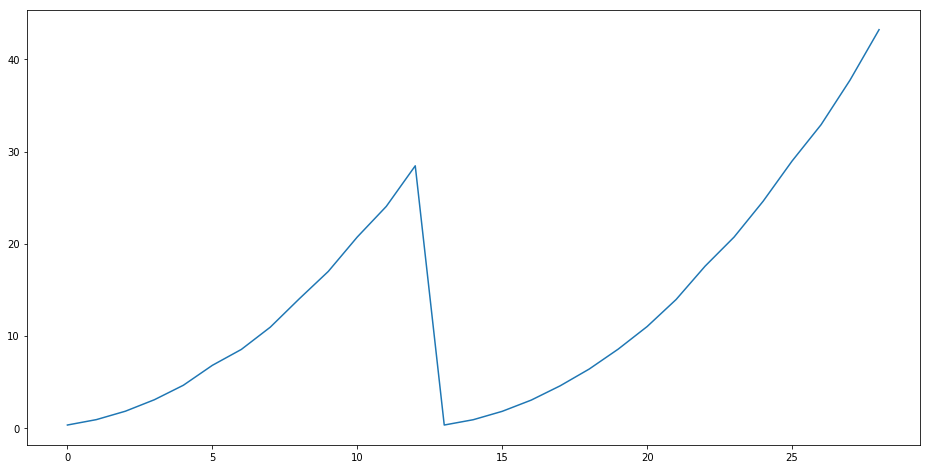

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(times, label='Time (seconds) per Data Stream')